In [2]:
import pandas as pd
import geopandas 
import matplotlib.pyplot as plt
import shapely.wkt
import osmnx as ox

### 02-waze-historical

 - read waze csvs

#### 1 Read Waze data

 - Waze csv stores `geo` column as strings instead of points, so need to use shapely to convert to shapely points [code from this thread](https://stackoverflow.com/questions/51855917/shapely-polygon-from-string)
 - Turn pandas dataframe into a GeoDataFrame

In [3]:
data = pd.read_csv('alerts_000000000000.csv')
geometry = data['geo'].map(lambda geo: shapely.wkt.loads(geo))
gdf = geopandas.GeoDataFrame(data, geometry=geometry)

#### 2 Filter data
 - Filter data for `'WEATHERHAZARD'` to ignore other road closures for different reasons. Assume that all weather hazards led to a road closure/road impassability

In [12]:
closures = gdf.loc[(data['type'] == 'WEATHERHAZARD')]
closures.head(10)
len(closures)

38

 - Alternatively, could filter for `subtype='ROAD_CLOSED_HAZARD'` and `subtype='WEATHERHAZARD'`

In [10]:
gdf.loc[(data['subtype'] == 'ROAD_CLOSED_HAZARD')]

,city,confidence,nThumbsUp,street,uuid,country,type,subtype,roadType,reliability,magvar,reportRating,ts,geo,geoWKT,geometry


 - Save geopandas as a shapefile, to put in QGIS

In [5]:
closures.to_file("weatherclosures.shp")

#### Plotting (optional)

 - Plot all alert data on India basemap to visualize, with help from [this article](https://towardsdatascience.com/the-easiest-way-to-plot-data-from-pandas-on-a-world-map-1a62962a27f3).

In [ ]:
place_name = 'Uttarakhand, India'
place = ox.geocode_to_gdf(place_name)
place_roi = place.iloc[0,0]
ax1 = place.plot(color='lightgrey')

fig, ax = plt.subplots(figsize=(8,6))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world[world["name"] == "Uttarakhand"].plot(color='lightgrey', ax=ax)
gdf.plot(ax=ax1, color='red')


In [ ]:
df = closures
# add new column to df
df['withinQ'] = ""

withinQlist = []
for lon,lat in zip(df.Longitude, df.Latitude):
    pt = Point(lon, lat)
    withinQ = pt.within(place['geometry'].values[0])
    #print( withinQ )
    withinQlist.append(withinQ)

# update values in the that column, values: True/False
df['withinQ'] = withinQlist

# select points within ecuador, assign to `result_df` dataframe
result_df = df[df.withinQ==True]
# select points outside ecuador, assign to `xresult_df` dataframe
xresult_df = df[df.withinQ==False]

# for checking/visualization, create a plot of relevant geometries
ax1 = place.plot(color='pink')
ax1.scatter(result_df.Longitude, result_df.Latitude, s=50, color='green')
#ax1.scatter(xresult_df.Longitude, xresult_df.Latitude, s=30, color='red')

 - Plot just weather closures, without India basemap

<AxesSubplot:>

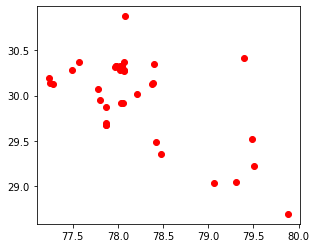

In [7]:
closures.plot(color='red')